# Example: Inferring causal structure using a pretrained AVICI model

Amortized variational inference for causal discovery (AVICI) allows inferring causal structure from data based on a **simulator** of the domain of interest. 
By training a neural network to infer structure from the simulated data, it can acquire realistic inductive biases from prior knowledge that is hard to cast as score functions or conditional independence tests.


In this example, we **download a pretrained model checkpoint and perform predictions** for a simulated dataset. Inferring causal structure with a pretrained AVICI model takes only a few seconds since it amounts to one forward pass through the neural network.

Setup for Google Colab (Skip this if running locally).


In [1]:
%pip install --quiet avici

**Simulate some data:**

The function `simulate_data` accepts the following most important arguments:
- **d** (int) -- number of variables in the system
- **n** (int) -- number of observational data points to be sampled
- **n_interv** (int) -- number of interventional data points to be sampled
- **domain** (str) -- specifier of domain to be simulated. Currently implemented options: `linear-gaussian-scm`, `rff-cauchy-scm`, `gene-ecoli` (all `.yaml` files inside `avici.config.examples`)

The function returns a 3-tuple of
- **g** -- `[d, d]` causal graph of `d` variables
- **x** -- `[n + n_interv, d]` data matrix containing `n + n_interv` observations of the `d` variables
- **interv** -- `[n + n_interv, d]` binary matrix indicating which nodes were intervened upon

In [2]:
import avici
from avici import simulate_data

# simulate data
g, x, interv = simulate_data(d=20, n=50, n_interv=10, domain="linear-gaussian-scm")

**Download and initialize a pretrained model:**

Based on our paper, we provide the pretrained weights for models trained on three data-generating processes, which are specified by the `download` argument:

- `linear`: SCM data with linear causal mechanisms
- `nonlinear`: SCM data with nonlinear causal mechanisms drawn from GPs with squared-exponential kernel (defined via random Fourier features)
- `sergio`: Synthetic scRNA-seq gene expression data using the SERGIO [simulator](https://github.com/PayamDiba/SERGIO) by [Dibaeinia and Sinha, (2020)](https://www.cell.com/cell-systems/pdf/S2405-4712(20)30287-8.pdf)

In [3]:
# load pretrained model
model = avici.load_pretrained(download="linear")

  0%|          | 184k/60.4M [00:00<00:37, 1.69MB/s]

**Predict the causal structure:**

Calling `model` as obtained from `avici.load_pretrained` predicts the `[d, d]` matrix of probabilities for each possible edge in the causal graph and accepts the following arguments:

- **x** (ndarray) -- real-valued data matrix of shape `[n, d]`
- **interv** (ndarray, optional) --  binary matrix of the same shape as **x** with **interv[i,j] = 1** iff node **j** was intervened upon in observation **i**. (Default is `None`)
- **return_probs** (bool, optional) -- whether to return probability estimates for each edge. `False` simply clips the predictions to 0 and 1 using a decision threshold of 0.5. (Default is `True` as the computational cost is the same.)


In [4]:
%%time
# g: [d, d] predicted edge probabilities of the causal graph
g_prob = model(x=x, interv=interv)

CPU times: user 8.69 s, sys: 147 ms, total: 8.84 s
Wall time: 8.53 s


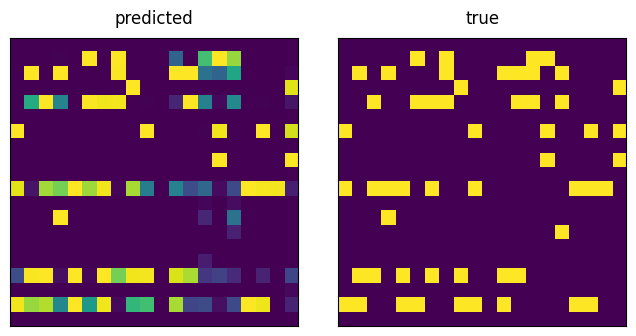

SHD:
13


In [5]:
from avici.metrics import shd

# visualize predictions and compute SHD
avici.visualize(g_prob, true=g, size=0.75)
print(f"SHD:\n{shd(g, (g_prob > 0.5).astype(int))}")